In [1]:
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import logging
import os
from main import run
from src.utils.config_setup import create_dirs
from src.datasets.data import Normalizer

In [ ]:
ROOT = os.getcwd()

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


In [ ]:
model_file = 'SINDDataset_pretrained_2024-04-27_00-11-45_KIP'

index = 2
index_data = 0
folder = 'experiments'

In [ ]:
import json

with open(f'{folder}/{model_file}/configuration.json') as f:
    config = json.load(f)
    config['save_dir'] = ROOT + f'/{folder}/' + config['save_dir'].split('/', index)[-1]
    config['output_dir'] = ROOT + f'/{folder}/' + config['output_dir'].split('/', index)[-1]  + '/eval'
    config['tensorboard_dir'] = ROOT + f'/{folder}/' + config['tensorboard_dir'].split('/', index)[-1] + '/eval'
    config['data_dir'] = ROOT + '/' + config['data_dir'].split('/', index_data)[-1]
    config['load_model'] = config['save_dir'] +'/model_best.pth'
    config['eval_only'] = True
    config['save_embeddings'] = True
    config['val_ratio'] = 1.0
    config['dropout'] = 0.0  # No dropout during evaluation
    config['hyperparameter_tuning'] = False

    create_dirs([config['output_dir']])
    
chunk_size =  config['data_chunk_len']

FileNotFoundError: [Errno 2] No such file or directory: 'ray_results_original/SINDDataset_pretrained_2024-04-08_19-13-17_U12/configuration.json'

In [ ]:
run(config)

2024-04-22 12:45:01,121 | INFO : Running:
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/ipykernel_launcher.py --f=/home/kfragkedaki/.local/share/jupyter/runtime/kernel-v2-523692fEwEF92rWqpj.json

2024-04-22 12:45:01,122 | INFO : Using device: cpu
2024-04-22 12:45:01,123 | INFO : Loading and preprocessing data ...
2024-04-22 12:45:01,125 | INFO : Loading 24 datasets files using 20 parallel processes ...
2024-04-22 12:45:02,036 | INFO : 10948 samples may be used for evaluation
2024-04-22 12:45:02,037 | INFO : 0 samples may be used for training
2024-04-22 12:45:02,038 | INFO : 10948 samples will be used for validation
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/ray_results_original/SINDDataset_pretrained_2024-04-08_19-13-17_U12/checkpoints/model_best.pth. Epoch: 33
Evaluating   0.0% | batch:         0 of        43	|	loss: 82.1135
Evaluating   2.3% | batch:         1 of        43	|	loss: 101.001
Evaluating   4.7% | batch:         2 of        43	|	loss: 105.442
Evaluating   7.0% | batch:         3 of        43	|	loss: 98.6857
Evaluating   9.3% | batch:         4 of        43	|	loss: 129.587
Evaluating  11.6% | batch:         5 of        43	|	loss: 156.556
Evaluating  14.0% | batch:         6 of        43	|	loss: 158.133
Evaluating  16.3% | batch:         7 of        43	|	loss: 166.468
Evaluating  18.6% | batch:         8 of        43	|	loss: 112.395
Evaluating  20.9% | batch:         9 of        43	|	loss: 98.9387
Evaluating  23.3% | batch:        10 of        43	|	loss: 99.8081
Evaluating  25.6% | batch:        11 of        43	|	loss: 101.282
Evaluating  27.9% | batch:        12 o

2024-04-22 12:45:12,277 | INFO : Evaluation Summary: loss: 114.466232 | 
2024-04-22 12:45:12,278 | INFO : Evaluation runtime: 0.0 hours, 0.0 minutes, 6.391331434249878 seconds



In [ ]:
# Load the file
pt_file = torch.load(f"{folder}/{model_file}/eval/output_data.pt") # chunk 50, batch size 16, with original data
original_pt_file = torch.load(f"{folder}/{model_file}/eval/original_data.pt") # chunk 50, batch size 16, with original data

# Print the head of the file
print(pt_file.keys(), original_pt_file.keys())

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs', 'padding_masks', 'embeddings', 'embeddings_original']) dict_keys(['train_data', 'val_data'])


In [ ]:
print(len(pt_file['embeddings'])) # (37, 256, 60, 128) -> number of batches, batch size, chunck size, embedding size
print(len(pt_file['embeddings'][0]))
print(len(pt_file['embeddings'][0][0]))
print(len(pt_file['embeddings'][0][0][0]))

43
256
50
128


In [ ]:
max(original_pt_file['val_data'].index.unique()), original_pt_file['val_data'].shape

(10947, (508615, 6))

In [ ]:
# Reshaping the DataFrame into a 3D list
result = []
feature_names = ["x", "y", "vx", "vy", "ax", "ay"]
padding_indicators = []

for key, group in original_pt_file['val_data'].groupby('data_chunk_len'):
    # For each group, convert it into a 2D list (where each sublist is a row in the group)
    chunks = group[feature_names].to_numpy()
    pad_length = chunk_size - chunks.shape[0]
    padded_chunks = np.pad(
        chunks,
        ((0, pad_length), (0, 0)),
        mode="constant",
        constant_values=0,
    )

     # Create an indicator array for padding
    # 0s for original data, 1s for padded data
    indicator_arr = np.zeros((chunks.shape[0], 1) , dtype=int)  # Initialize with zeros, indicating original data

    if pad_length > 0:
        # Create padding indicators (1s) and append to the original indicator array
        padding_indicator = np.ones((pad_length, 1), dtype=int)
        indicator_arr = np.vstack((indicator_arr, padding_indicator))
    
    padding_indicators.append(indicator_arr[:, 0])
    result.append(padded_chunks)


In [ ]:
padding_indicators = np.array(padding_indicators)

In [ ]:
all_data = np.concatenate(pt_file['targets'], axis=0)
all_data_original = np.array(result)
all_embeddings = np.concatenate(pt_file['embeddings'], axis=0)
all_embeddings_original = np.concatenate(pt_file['embeddings_original'], axis=0)
all_predictions = np.concatenate(pt_file['predictions'], axis=0)

padding_masks = np.concatenate(pt_file['padding_masks'], axis=0)
target_masks = np.concatenate(pt_file['target_masks'], axis=0)
padding_indicators = np.array(padding_indicators)

In [ ]:
(padding_masks == (padding_indicators == 1)).sum()

0

# Predictions

In [ ]:
import osmium as osm
from src.datasets.plot import SinDMap
from shapely.geometry import Point

In [ ]:
map = SinDMap()

In [ ]:
batch_id = padding_masks.shape[0] -1

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


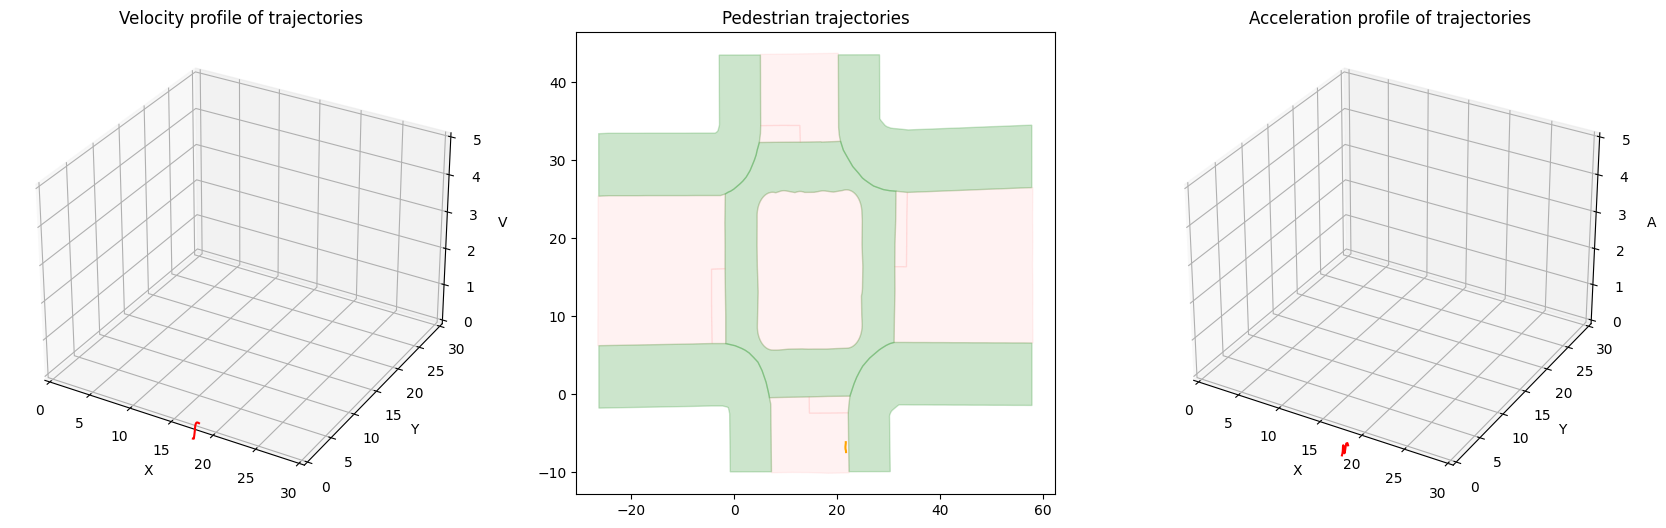

In [ ]:
# orginal data (before normalization, if applied
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_data_original[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

In [ ]:
# real_data = ~target_masks[batch_id][:, 0]*padding_masks[batch_id]
# real_data
real_data = (~target_masks*np.repeat(padding_masks[:, :, np.newaxis], 6, axis=2))
trained_data = (target_masks*np.repeat(padding_masks[:, :, np.newaxis], 6, axis=2))

In [ ]:
(padding_masks[batch_id] == False).sum(), target_masks[batch_id][:, 0].sum(), (real_data[batch_id, :, 0] == False).sum(), (trained_data[batch_id, :, 0] == True).sum()

(35, 35, 35, 0)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


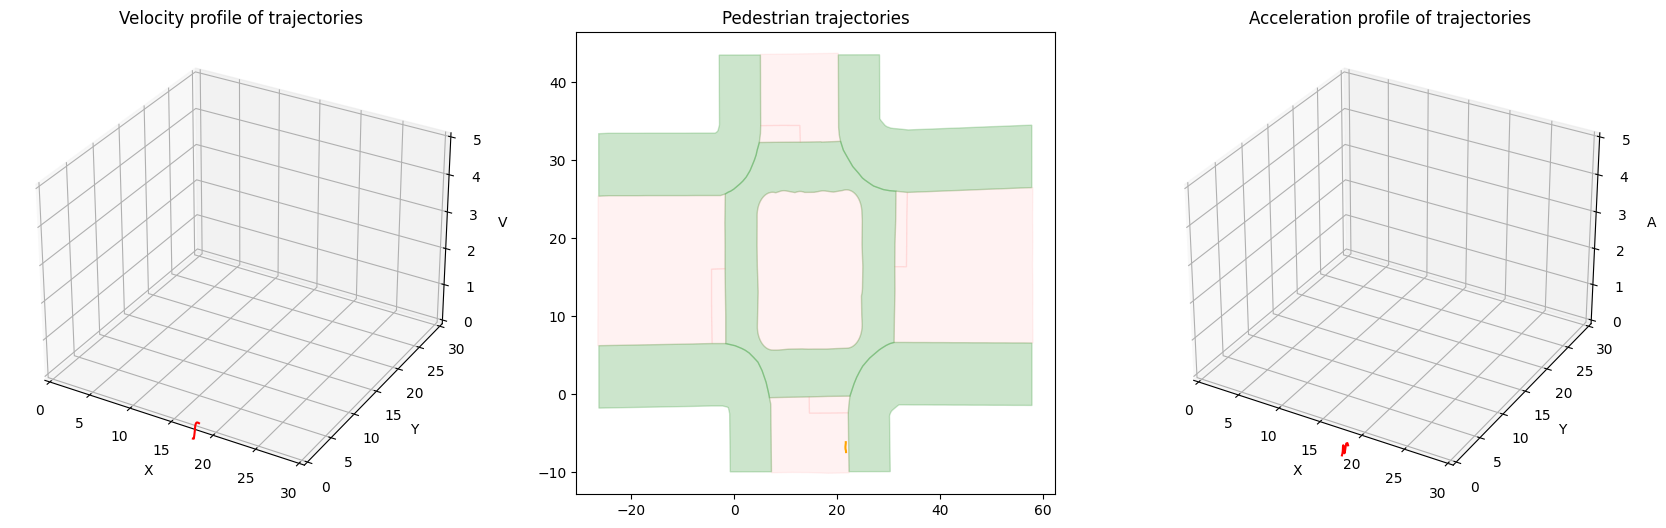

In [ ]:
# target data (after normalization, if applied)
# config['data_normalization']  = "minmax"
if config['data_normalization'] != "none":
    normalizer = Normalizer(norm_type = config['data_normalization'])
    normalized_df = normalizer.normalize(all_data_original)
    map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(normalized_df[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_data[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

In [ ]:
# the padded data and the target are predicted correctly, the real data are not predicted correctly
real_data[batch_id, :, 0], padding_masks[batch_id]

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]))

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


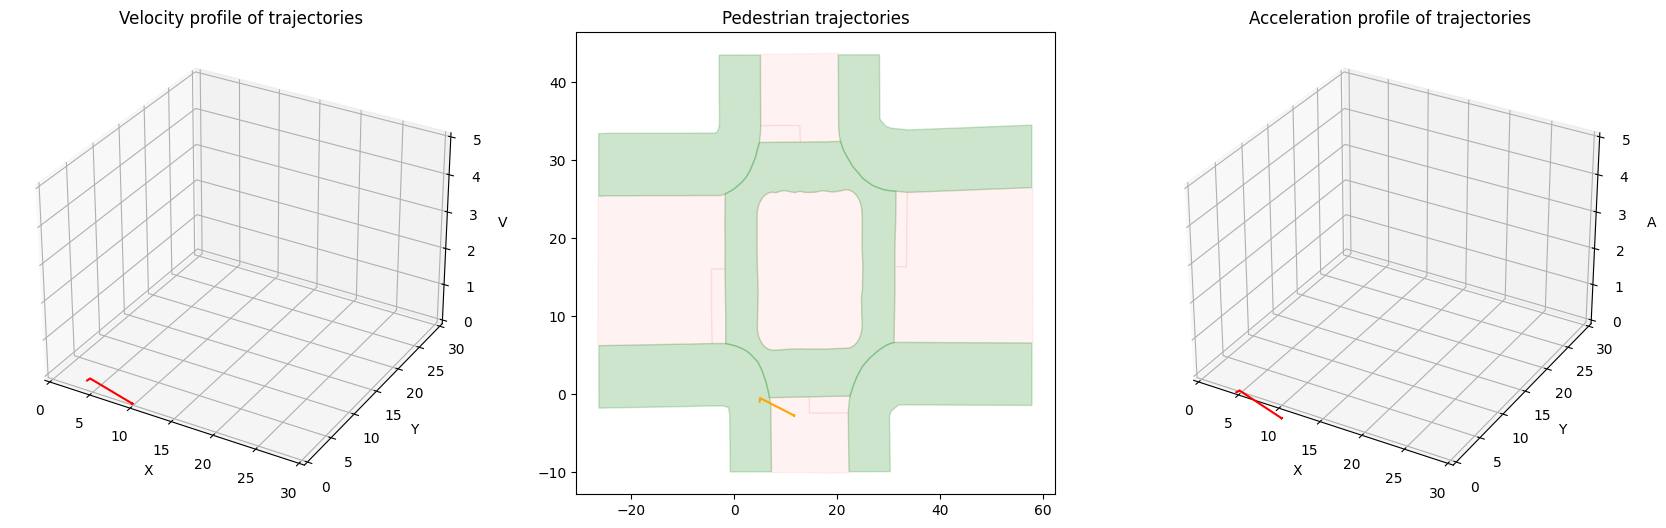

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


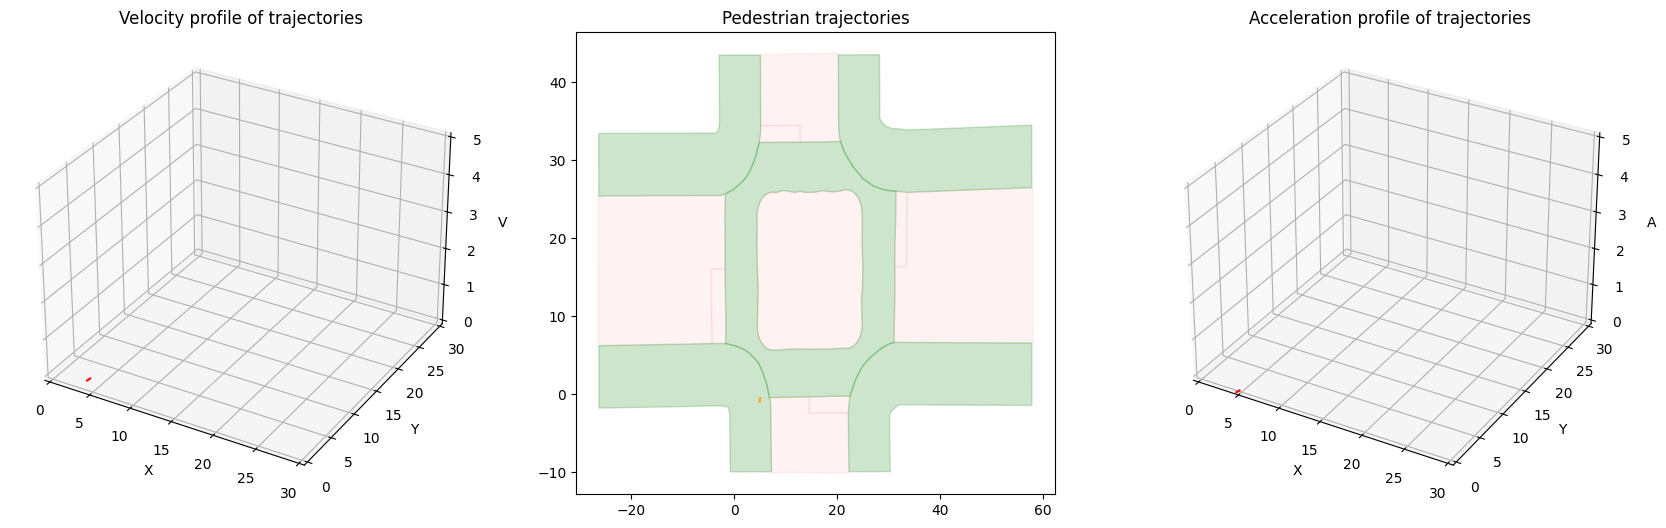

In [ ]:
# predicted data before
# the padded data and the target are predicted correctly, the real data are not predicted correctly
if config['data_normalization'] != "none":
    original_df = normalizer.inverse_normalize(all_predictions)
    map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(original_df[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=~padding_masks)

map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_predictions[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])})
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_predictions[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=real_data[:, :,0])

# Create clusters

In [ ]:
# Flatten the sequence_length and features dimensions
df_predicted = pd.DataFrame(all_embeddings.reshape(all_embeddings.shape[0], -1)) # flatten data merge first two dimensions
df_target = pd.DataFrame(all_data_original.reshape(all_data_original.shape[0], -1)) # flatten data merge first two dimensions
df_predicted.shape,  df_target.shape, all_embeddings.shape

((10948, 6400), (10948, 300), (10948, 50, 128))

### K-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Perform K-Means clustering
# Encoded embeddings where created throuth a transformer model that was designed to ignore the padded values
scores = {}
for n_clusters in range(2, 100):
    kmeans = KMeans(n_clusters=n_clusters)  # Choose an appropriate number of clusters
    clusters = kmeans.fit_predict(df_predicted)

    score = silhouette_score(df_predicted.iloc[:, :-1], clusters)
    print("Silhouette Score: ", score, "for n_clusters: ", n_clusters)
    scores[n_clusters] = score

# Silhouette Score:  0.31312647 for n_clusters:  4

Silhouette Score:  0.4922873 for n_clusters:  2
Silhouette Score:  0.11046515 for n_clusters:  3
Silhouette Score:  0.06714076 for n_clusters:  4
Silhouette Score:  0.06310618 for n_clusters:  5
Silhouette Score:  0.037074313 for n_clusters:  6
Silhouette Score:  0.059145387 for n_clusters:  7
Silhouette Score:  0.03492436 for n_clusters:  8
Silhouette Score:  0.03159302 for n_clusters:  9
Silhouette Score:  0.037229568 for n_clusters:  10
Silhouette Score:  0.023167517 for n_clusters:  11
Silhouette Score:  0.03171171 for n_clusters:  12
Silhouette Score:  0.029103182 for n_clusters:  13
Silhouette Score:  0.032840516 for n_clusters:  14
Silhouette Score:  0.026114266 for n_clusters:  15
Silhouette Score:  0.024458585 for n_clusters:  16
Silhouette Score:  -0.07757223 for n_clusters:  17
Silhouette Score:  0.037911873 for n_clusters:  18
Silhouette Score:  -0.07145947 for n_clusters:  19
Silhouette Score:  0.016280875 for n_clusters:  20
Silhouette Score:  0.014329469 for n_clusters: 

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(scores.values(), index=scores.keys())
df.to_csv(f'k-means_scores_{folder}_{model_file}.csv')

In [ ]:
max(scores.values()), max(scores, key=scores.get)

(0.4922873, 2)

### DBSCAN

In [ ]:
all_embeddings.shape,  all_data_original.shape

((10948, 50, 128), (10948, 50, 6))

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
scores = { 'non_filtered' : {}, 'filtered' : {}}
# You may need to experiment with different ranges and granularity of eps and min_samples
eps_values = np.linspace(0.1, 1.0, 2)  # Adjust these values based on the scale of your data
min_samples_values = range(2, 10)  # Common starting point

best_score_filtered = -1
best_params_filtered = None

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(all_embeddings)
        
        # Check if we have more than one cluster (-1 is noise)
        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        if len(set(clusters)) - (1 if -1 in clusters else 0) > 1:
            print("Number of data unclustered vs clustered:", len(clusters[clusters == -1]), len(clusters))
            score = silhouette_score(all_embeddings, clusters)
            scores['non_filtered'][(eps, min_samples)] = score
            
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

            score_filtered = silhouette_score(all_embeddings[clusters!=-1], clusters[clusters!=-1])
            scores['filtered'][(eps, min_samples)] = score_filtered

            if score_filtered > best_score_filtered:
                best_score_filtered = score_filtered
                best_params_filtered = (eps, min_samples)

            print("Silhouette Score: ", score, "Filtered Silhouette Score: ", score_filtered, "for eps:", eps, "min_samples:", min_samples, "num_clusters:", num_clusters)
        else:
            print("Less than 2 clusters for eps:", eps, "min_samples:", min_samples, "num_clusters:", num_clusters)

if best_params:
    print("Best Silhouette Score:", best_score, "achieved with eps =", best_params[0], "and min_samples =", best_params[1])
    print("Best Filtered Silhouette Score:", best_score_filtered, "achieved with eps =", best_params_filtered[0], "and min_samples =", best_params_filtered[1])
else:
    print("No valid clustering found for any parameter combination.")



### HDBSCAN

In [ ]:
all_embeddings.shape,  all_data_original.shape

((10948, 50, 128), (10948, 50, 6))

In [ ]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
from sklearn.cluster import HDBSCAN

# Assuming embeddings is your array of shape (10948, 50, 128)
# Apply mean pooling across the time steps
data_pooled = np.mean(all_embeddings, axis=1)

# Cluster the data
hdbscan = HDBSCAN(min_cluster_size=5, min_samples=30)
clusters = hdbscan.fit_predict(data_pooled)

print("Cluster assignments:", len(set(clusters)))

Cluster assignments: 31


In [ ]:
scores = { 'non_filtered' : {}, 'filtered' : {}}
best_score_filtered = -1
best_params_filtered = None

best_score = -1

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
if len(set(clusters)) - (1 if -1 in clusters else 0) > 1:
    print("Number of data unclustered vs clustered:", len(clusters[clusters == -1]), len(clusters))
    score = silhouette_score(data_pooled, clusters)
    scores['non_filtered']= score
    
    if score > best_score:
        best_score = score

    score_filtered = silhouette_score(data_pooled[clusters!=-1], clusters[clusters!=-1])
    scores['filtered'] = score_filtered

    if score_filtered > best_score_filtered:
        best_score_filtered = score_filtered

    print("Silhouette Score: ", score, "Filtered Silhouette Score: ", score_filtered, "num_clusters:", num_clusters)
else:
    print("Less than 2 clusters for eps:", eps, "min_samples:", min_samples, "num_clusters:", num_clusters)


Number of data unclustered vs clustered: 7874 10948
Silhouette Score:  -0.41229925 Filtered Silhouette Score:  0.3410235 num_clusters: 30


In [ ]:
df_predicted['clusters'] = clusters
max(df_predicted['clusters']), min(df_predicted['clusters'])

(29, -1)

### Plot Trajectories (Starting+Ending point) based on Clustering

In [ ]:
import matplotlib.cm as cm
cmap = cm.get_cmap('hsv')
num_clusters = max(df_predicted['clusters']) + 1
COLOR_PALETE = [cmap(i / num_clusters) for i in range(num_clusters)]

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


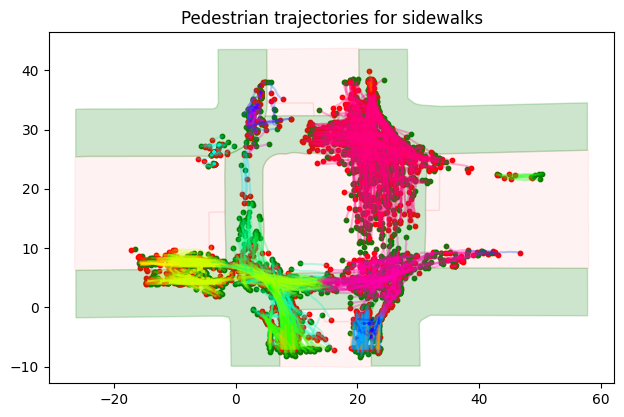

In [ ]:
ax = map.plot_areas(alpha=0.2)
ax.set_title(f"Pedestrian trajectories for sidewalks" )

for cluster in df_predicted['clusters'][df_predicted['clusters']!=-1].unique():
    cluster_df = df_target[df_predicted['clusters'] == cluster]

    trajectories = {}
    for index, row in cluster_df.iterrows():
        trajectories[index] = row.values.reshape(-1, 6)
    
    map.plot_dataset(pedestrian_data=trajectories, ax=ax, color=COLOR_PALETE[cluster], title=f'cluster_{cluster}', alpha_trajectories=0.3, padding_masks=padding_masks)

# Clusters in Map

### Color Pallete

In [ ]:
num_clusters = len(set(clusters))
# num_clusters = max(set(df_predicted['clusters'])) + 1 # len(set(clusters_df[key])) #

In [ ]:
COLORS = ['#EF3D59', '#E17A47', '#EFC958', '#4AB19D',  '#344E5C', '#A6206A', '#568EA6', '#A2D4AB', '#5A5050']

In [ ]:
# COLOR_PALETE = COLOR_PALETE + sns.color_palette("tab10", 20) + sns.color_palette("Pastel1", 20) + sns.color_palette("Dark2", 20) + sns.color_palette("hsv", 5)

In [ ]:
import matplotlib.cm as cm
cmap = cm.get_cmap('hsv')
COLOR_PALETE = [cmap(i / num_clusters) for i in range(num_clusters)]

### Split All Trajectories based on the Labels defined by Soderlund et al.

In [ ]:
from src.datasets.labeling_oracle import LabelingOracleSINDData, LABELS

In [ ]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

In [ ]:
labeling_oracle = LabelingOracleSINDData(config)

2024-04-22 12:55:33,960 | INFO : Loading 24 datasets files using 20 parallel processes ...


In [ ]:
all_data_original.shape, padding_masks.shape

((10948, 50, 6), (10948, 50))

In [ ]:
df_predicted.shape, df_target.shape

((10948, 6401), (10948, 300))

In [ ]:
labels = labeling_oracle.labels(all_data_original)
labels.shape

Labeling data: 100%|██████████| 10948/10948 [00:01<00:00, 9783.25it/s]


(10948,)

In [ ]:
labels = pd.DataFrame(labels, columns=['label'])
df_dataset = pd.DataFrame(all_data_original.reshape(all_data_original.shape[0], -1))

In [ ]:
trajectories = {feature: {} for feature in labels['label'].unique()}
trajectories_new = {feature: {} for feature in labels['label'].unique()}
padding_masked = {feature: {} for feature in labels['label'].unique()}
clusters_df = {feature: {} for feature in labels['label'].unique()}

for feature in labels['label'].unique():
    feature_df = df_dataset[labels['label'] == feature]
    padding_masked[feature] = padding_masks[labels['label'] == feature]
    clusters_df[feature] = clusters[labels['label'] == feature]

    for i, (index, row) in enumerate(feature_df.iterrows()):
        trajectories[feature][i] = row.values.reshape(-1, 6)
    
    for i, (index, row) in enumerate(feature_df[clusters_df[feature] != -1].iterrows()):
        trajectories_new[feature][i] = row.values.reshape(-1, 6)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


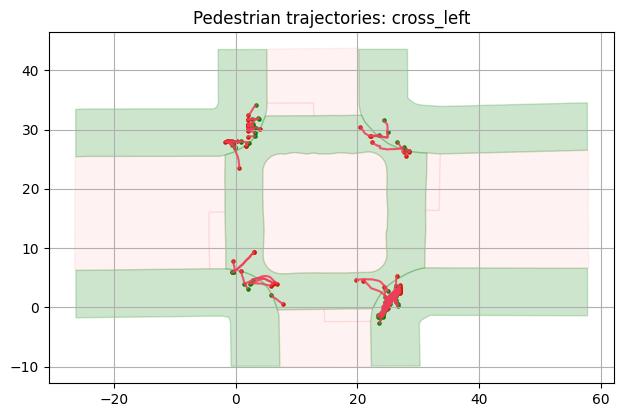

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


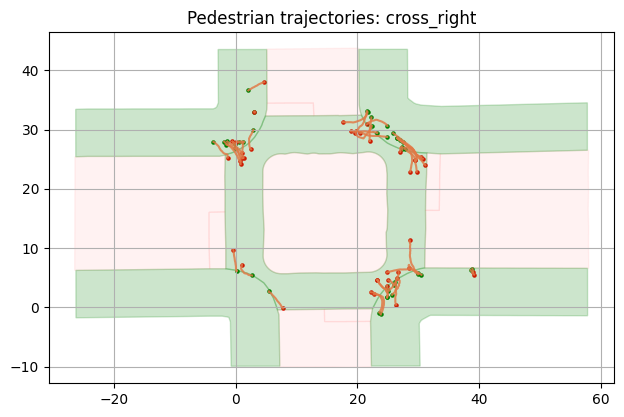

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


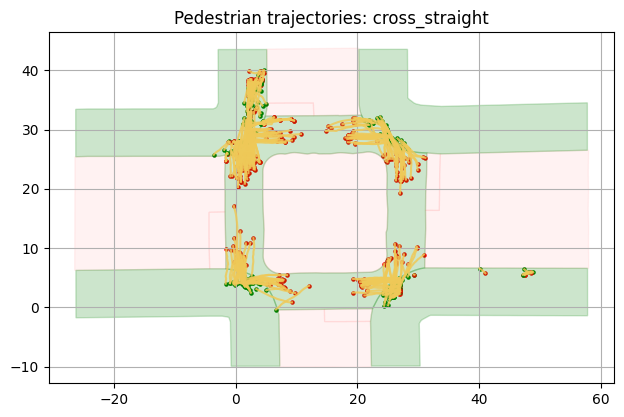

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


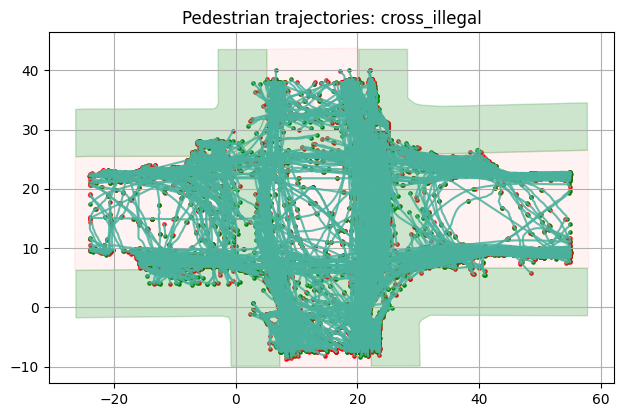

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


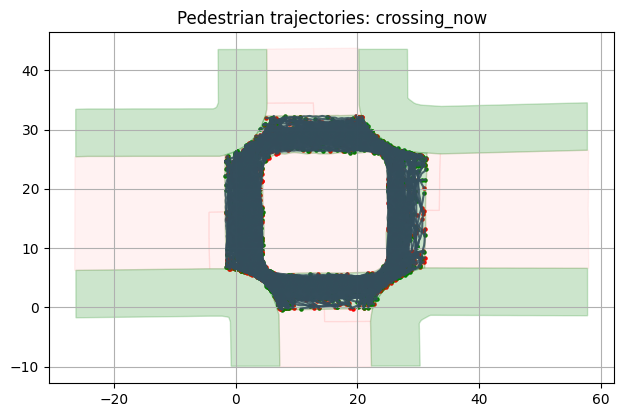

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


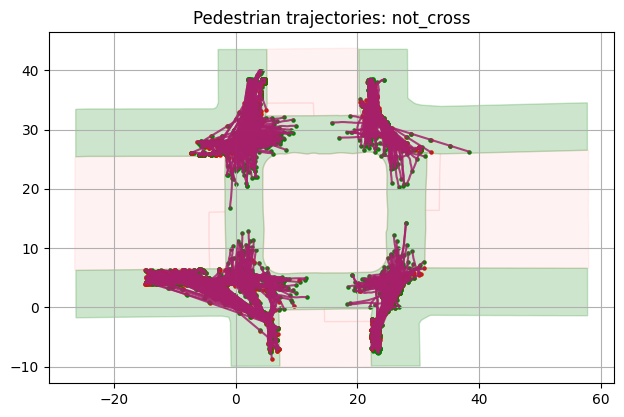

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


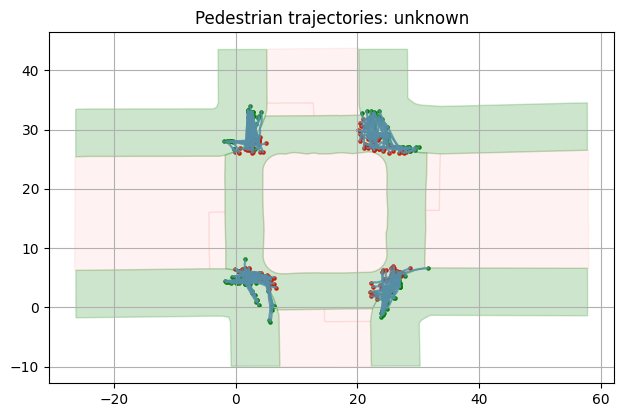

In [ ]:
for key in REVERSED_LABELS.keys():
    labeling_oracle.map.plot_dataset(pedestrian_data=trajectories[key], color=COLORS[key], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=.85, size_points=5, padding_masks=padding_masked[key])

### PLot Trajectories based on the Predefined Labels - Color Trajectories based on the Cluster

In [ ]:
REVERSED_LABELS

{0: 'cross_left',
 1: 'cross_right',
 2: 'cross_straight',
 3: 'cross_illegal',
 4: 'crossing_now',
 5: 'not_cross',
 6: 'unknown'}

In [ ]:
key = 3
padding_masked[key].shape, clusters_df[key].shape, len(trajectories[key]), trajectories[key][0].shape

((4884, 50), (4884,), 4884, (50, 6))

In [ ]:
# unique_clusters = len(set(clusters_df[key]))
# # Create the mapping from old values to consecutive new values
# mapping = {old_val: new_val for new_val, old_val in enumerate(sorted(unique_clusters))}

# clusters_df_new = pd.DataFrame(clusters_df[key])
# # Apply the mapping to the DataFrame column 'key'
# clusters_df_new = clusters_df_new[0].map(mapping)

# labeling_oracle.map.plot_dataset_color_clusters(pedestrian_data=trajectories_new[key], colors=COLOR_PALETE, clusters=clusters_df_new[clusters_df_new!= 0].to_numpy(), title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=0, padding_masks=padding_masked[key][clusters_df_new!= 0])

In [ ]:
len(COLOR_PALETE), len(set(clusters_df[key]))#, len(mapping)

(30, 26)

In [ ]:
len(clusters_df[key]), len(trajectories[key]), len(padding_masked[key])

(4884, 4884, 4884)

With Undefined Clusters (Cluster -1)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


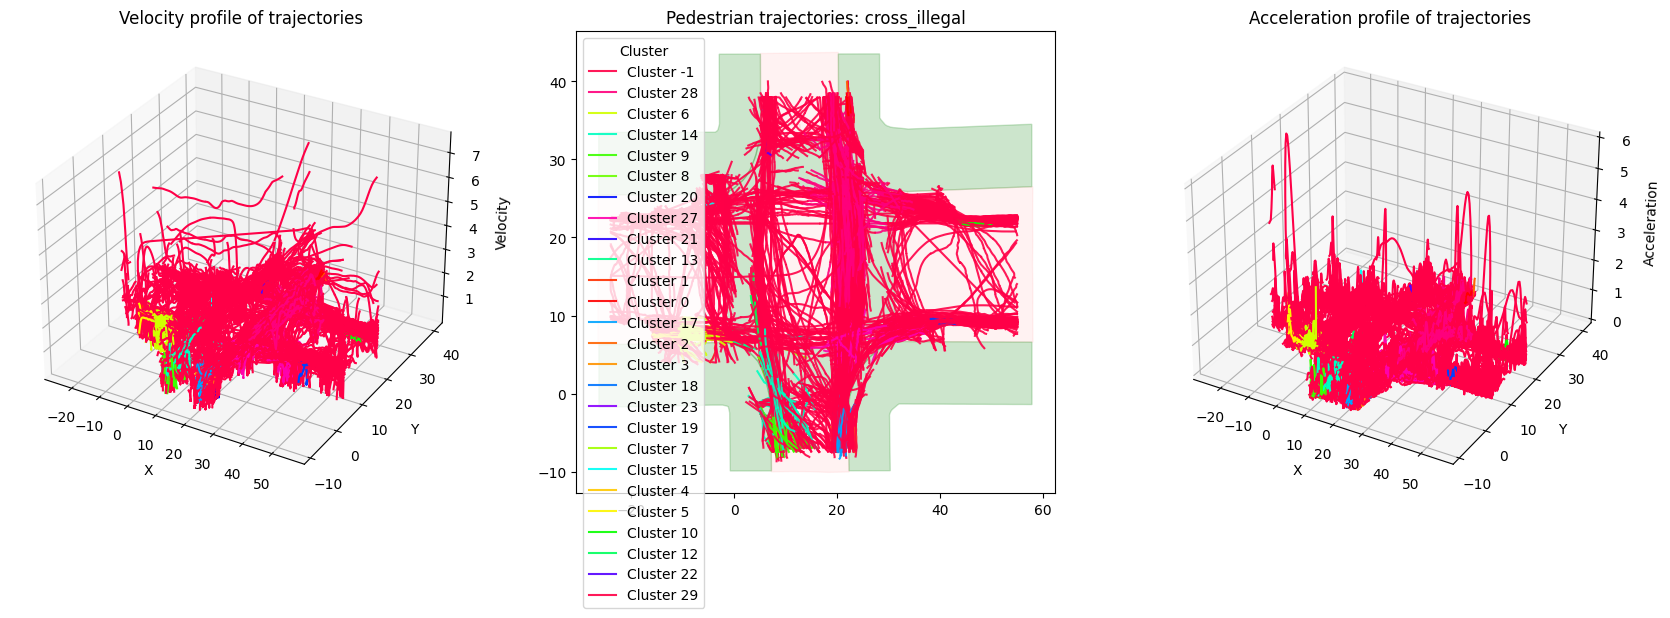

In [ ]:
labeling_oracle.map.plot_dataset_color_clusters(pedestrian_data=trajectories[key], colors=COLOR_PALETE, clusters=clusters_df[key], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=0, padding_masks=padding_masked[key])

Without Undefined Clusters (Cluster != -1)

In [ ]:
len(clusters_df[key][clusters_df[key]!= -1]), len(trajectories_new[key]), len(padding_masked[key][clusters_df[key]!= -1])

(1048, 1048, 1048)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


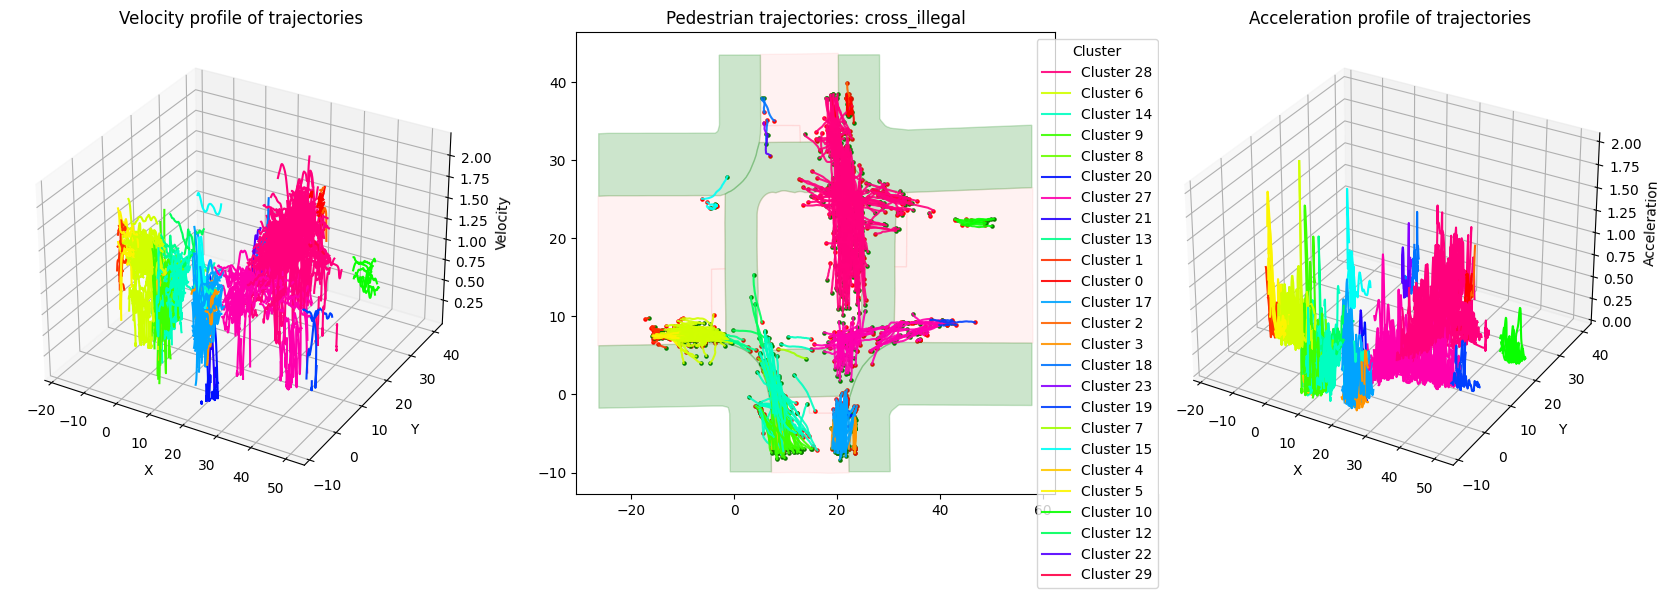

In [ ]:
labeling_oracle.map.plot_dataset_color_clusters_all(pedestrian_data=trajectories_new[key], colors=COLOR_PALETE, clusters=clusters_df[key][clusters_df[key]!= -1], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=5, padding_masks=padding_masked[key][clusters_df[key]!= -1])

### Plot the Distribution of Predefined Labels in a Cluster

In [ ]:
data_pool_original = pd.DataFrame(np.mean(all_data_original, axis=1), columns=["x", "y", "vx", "vy", "ax", "ay"])
clusters_df_ = pd.DataFrame(clusters, columns=['cluster'])
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df['label'] = labels_df['label'].map(pd.DataFrame(REVERSED_LABELS.values(), index=REVERSED_LABELS.keys())[0])

In [ ]:
data_pool_original.shape, clusters_df_.shape, labels_df.shape

((10948, 6), (10948, 1), (10948, 1))

In [ ]:
cluster_features = pd.concat([labels_df, clusters_df_, data_pool_original], axis=1)

In [ ]:
# Aggregate data by cluster and category
category_counts = cluster_features.groupby(['cluster', 'label']).size().unstack(fill_value=0)

# Normalize the counts to get proportions within each cluster
category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)

In [ ]:
# category_proportions_per_category = category_counts.div(category_counts.sum(axis=0), axis=1)

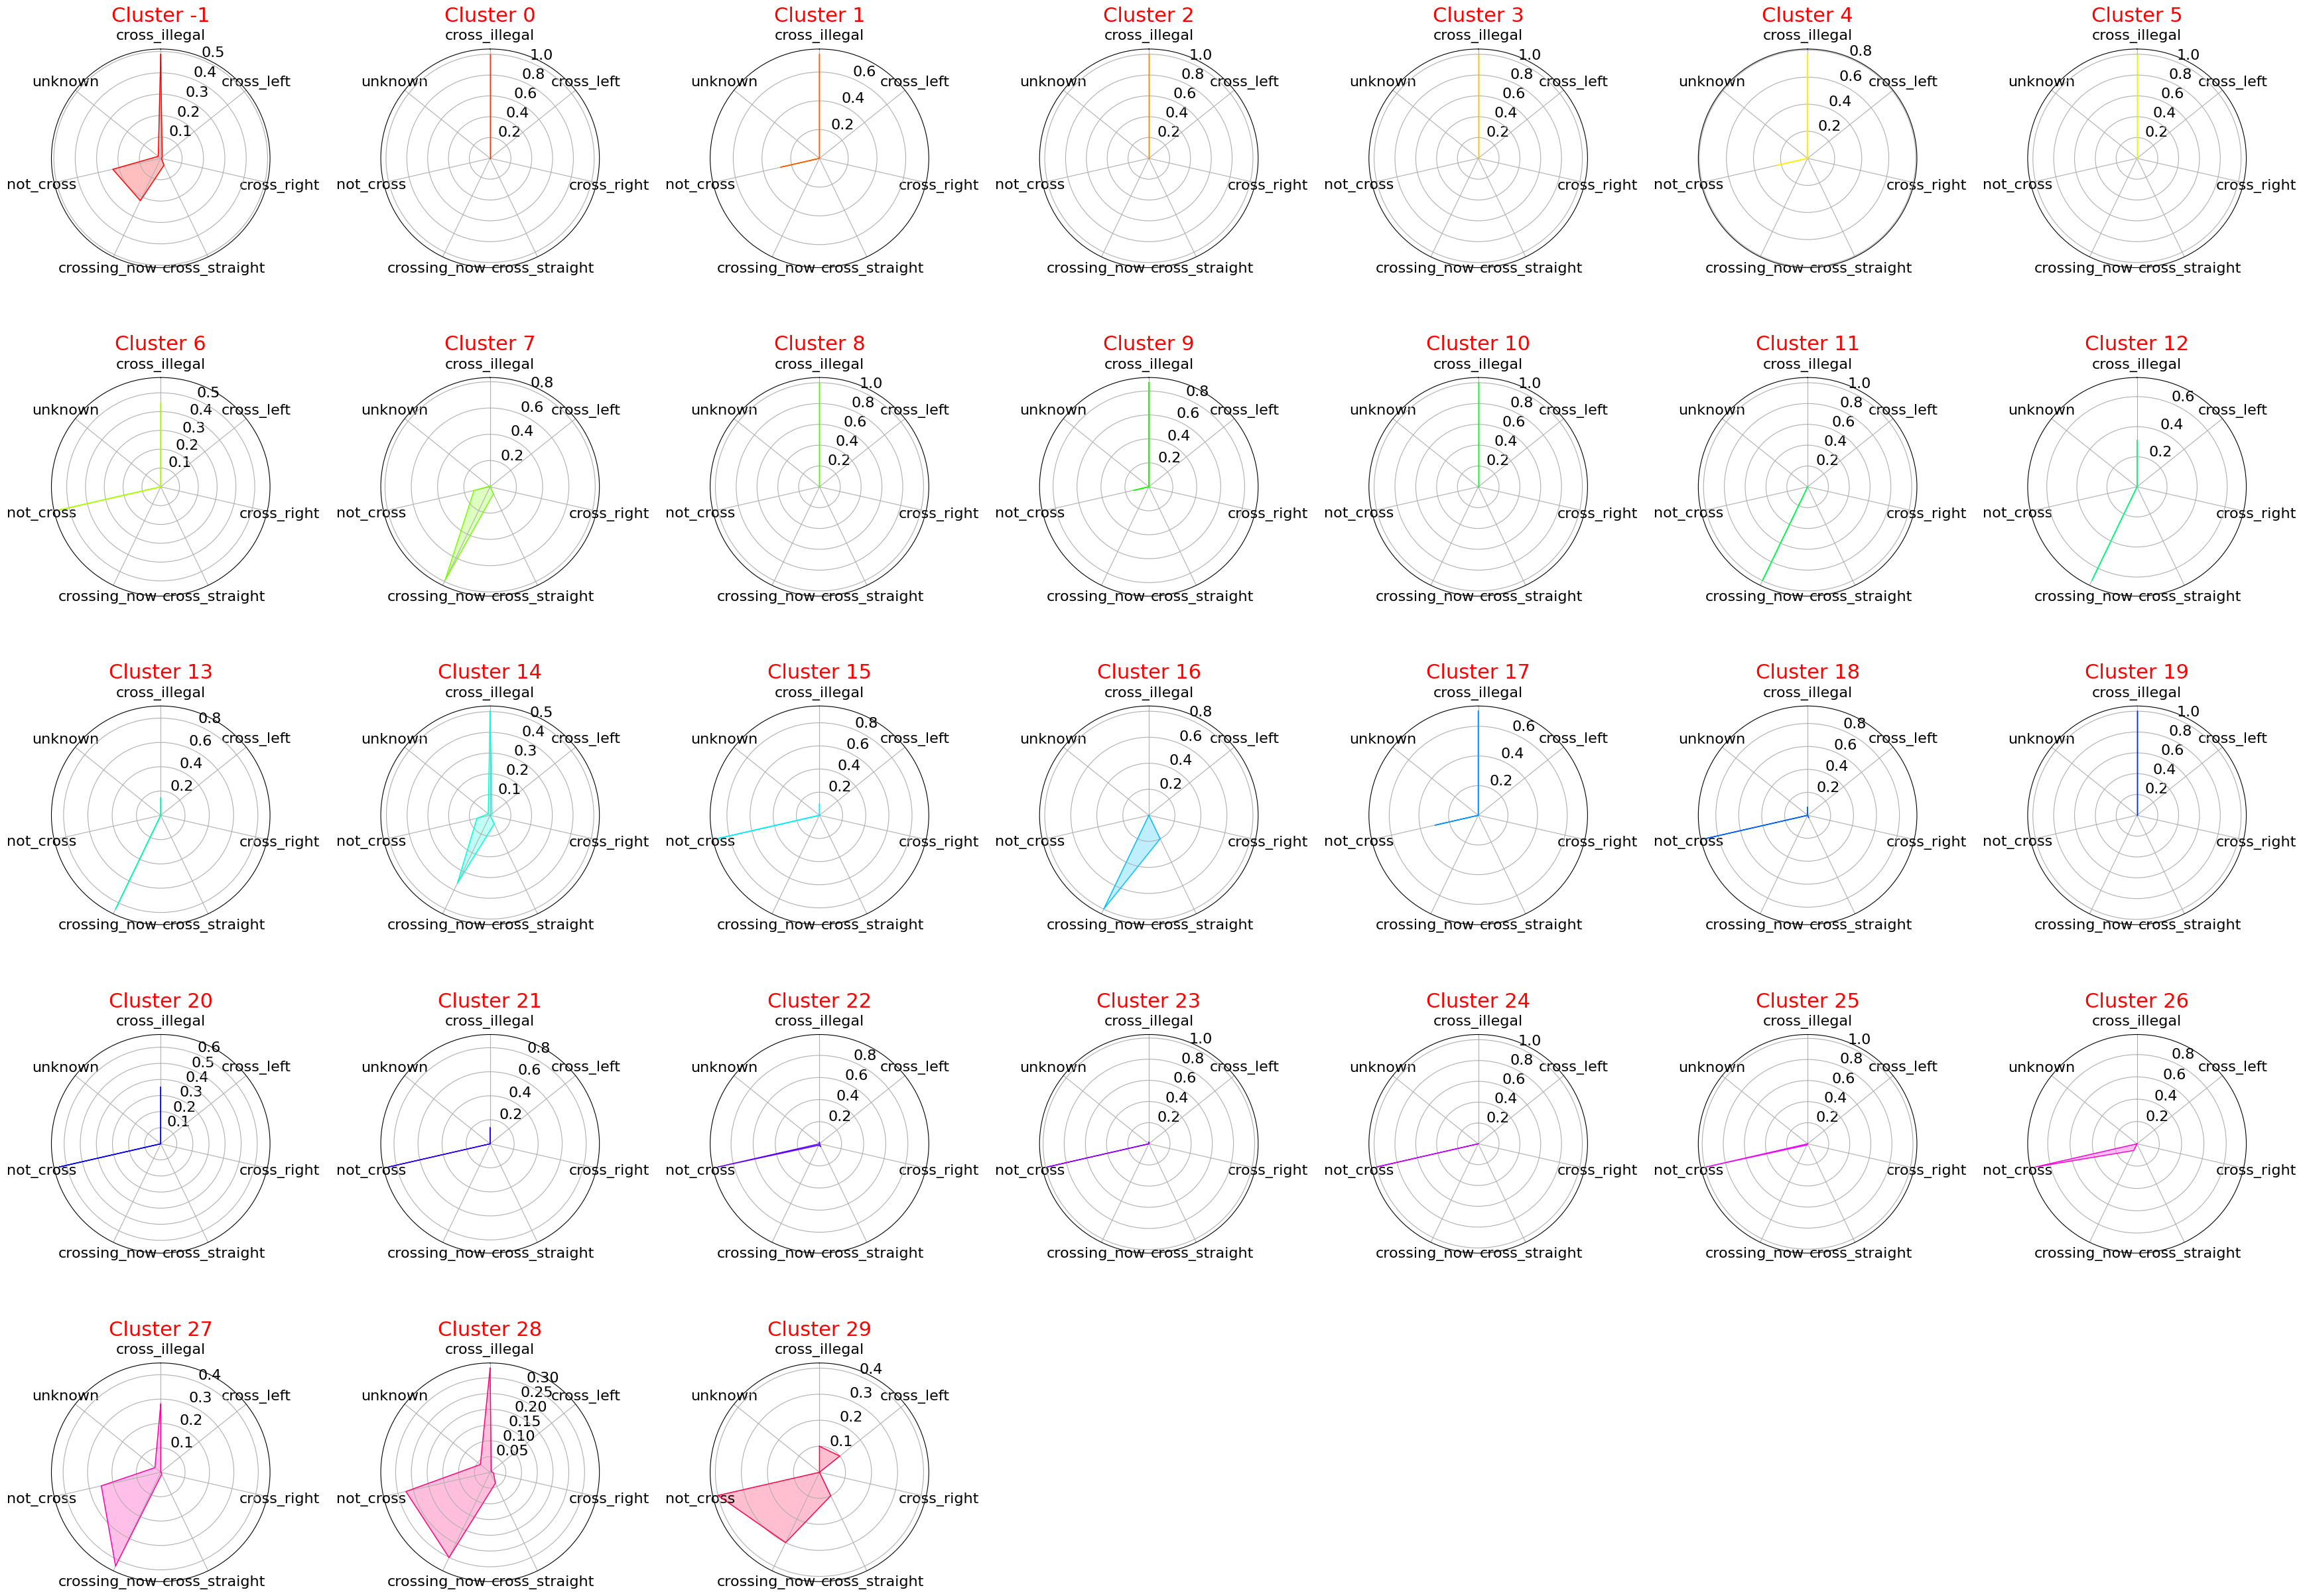

In [ ]:
# Plotting Radar Chart 
def plot_radar_chart(ax, values, categories, title, color):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = values.tolist() + values.tolist()[:1]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.plot(angles, values, color=color, linewidth=1, linestyle='solid', label=title)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(title, size=22, color='red', y=1.1)


# Set up the figure for radar charts
num_clusters = len(category_proportions)
cols = 7  # Max number of columns per row
rows = (num_clusters + cols - 1) // cols  # Calculate required number of rows
fig, axs = plt.subplots(figsize=(cols * 5, rows * 5), nrows=rows, ncols=cols, subplot_kw=dict(polar=True))
plt.rcParams.update({'font.size': 16})
axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

# Plot each cluster's radar chart
for i, (idx, row) in enumerate(category_proportions.iterrows()):
# for i, (idx, row) in enumerate(category_proportions_per_category.iterrows()):
    plot_radar_chart(axs[i], row, row.index, f'Cluster {idx}', color=COLOR_PALETE[i])

# Hide unused axes
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# def add_radar_chart(ax, values, categories, title, color):
#     num_vars = len(categories)
#     angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
#     angles += angles[:1]  # Complete the loop

#     ax.set_theta_offset(np.pi / 2)
#     ax.set_theta_direction(-1)
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories)

#     values += values[:1]
#     ax.plot(angles, values, color=color, linewidth=1, linestyle='solid', label=title)
#     ax.fill(angles, values, color=color, alpha=0.25)
#     ax.set_title(title, size=15, color='red', y=1.1)

# def plot_clusters(features_df, num_clusters, colors, plot_labels=False):
#     # Columns per row
#     cols_per_row = 4
#     # Calculate number of rows needed
#     rows = (num_clusters + cols_per_row - 1) // cols_per_row  # Ceiling division

#     # Create subplots with dynamic rows and columns
#     fig, axs = plt.subplots(rows, cols_per_row, subplot_kw=dict(polar=True), figsize=(4 * cols_per_row, 4 * rows))
    
#     # Flatten axs array for easier iteration if it's multidimensional
#     if num_clusters > 1:
#         axs = axs.flatten()

#     for i in range(num_clusters):
#         if plot_labels:
#             categories = list(set(cluster_features['label']))
#             cluster_data = cluster_features[cluster_features['cluster'] == 3-1]['label'].value_counts().reindex(categories, fill_value=0)
#         else:
#             categories = list(features_df.columns[2:])  # assuming the first two columns are 'label' and 'cluster'
#             cluster_data = features_df[features_df['cluster'] == i-1][categories].mean()  # mean of each feature in this cluster
#         add_radar_chart(axs[i], cluster_data[categories].tolist(), categories, f'Cluster {i-1}', color=colors[i])

#     # Hide any unused subplots
#     for ax in axs[num_clusters:]:
#         ax.set_visible(False)

#     plt.tight_layout()
#     plt.show()

# plot_clusters(cluster_features, len(set(clusters_df_['cluster'])), colors=COLOR_PALETE)

# Reachability Analysis

In [ ]:
from src.reachability_analysis.simulation import visualize_scenario

In [ ]:
def get_modal_zonotopes_for_scenarios(data, labels):
    """Code to reproduce the modal zonotopes and baseline zonotopes
    for the 3 scenarios.
    """

    _dict = {
        1: ["cross_right", "cross_straight"],
        2: ["cross_left", "cross_straight"],
        3: ["crossing_now", "cross_illegal"],
    }
    for i in range(1, 4):
        print(f"Running scenario {i}")
        run_scenario(i)
    for i in range(1, 4):
        try:
            visualize_scenario(
                scenario=str(i), all_modes=False, save=True, overlay_image=True
            )
        except Exception:
            print(f"Not possible to visualize any modal zonotopes for scenario {i}")
            break
        plt.close("all")
        for mode in _dict[i]:
            try:
                fig, ax = plt.subplots()
                fig.subplots_adjust(top=1, left=0, bottom=0, right=1)
                im = plt.imread(os.getcwd() + f"/resources/scenario{i}{mode}.png")
                ax.imshow(im)
                plt.axis("off")
                plt.show()
            except Exception:
                print(f"{mode} not computed for scenario {i}. Solutions:")
                print(" - Get the full dataset")
                print(" - Try running code again")

In [ ]:
    # if not _sind_:
    #     _sind = LabelingOracleSINDData()
    # else:
    #     _sind = _sind_
    # if type(_d) is not np.ndarray:
    #     if input_len == 90:
    #         data = load_data()
    #         labels = load_data("sind_labels.pkl")
    #         train_data, _, train_labels, _ = split_data(data, labels)
    #     else:
    #         data = _sind.data(input_len=input_len)
    #         labels = _sind.labels(data, input_len=input_len)
    #         train_data, _, train_labels, _ = split_data(data, labels)
    #     train_data, train_labels = structure_input_data(train_data, train_labels)
    #     d = separate_data_to_class(train_data, train_labels)
    # else:
    #     d = _d